<h3> Project: Benchmarking of GTM and other machine learning methods on prediction of aqueous solubility of organic compounds </h3>

<h4>Summary</h4>
A performance comparison of GTM and kGTM against several well-established machine learning methods is made, with the main goal being prediction of aqueous solubiity of organic compounds. A curated datasset of 9982 compounds was taken from kaggle (<a href="https://www.kaggle.com/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset" target="_blank">https://www.kaggle.com/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset</a>). The dataset was striped of salts and compounds with multiple occurences. The RDkit module was Chem was used to calculate 2D autocorrelation descriptors based on <u>topological properties</u> (to be checked). A set of two machine learning models was built for each method, one based on the descriptors provided in the original dataset, and another based on the autocorrelation descriptors.

<h4>To do list</h4>
<ul>
    <li>prepare the training and test set using "original" descriptors</li>
    <li>prepare the training and test set using RDkit AUTOCORR2D descriptors</li>
    <li>build the GTM and kGTM machine learning models</li>
    <li>build other machine learning models:</li>
    <ul>
        <li>Ridge Regression</li>
        <li>suppoort vector machine with rbf kernel</li>
        <li>random forest</li>
        <li>k-NN</li>
    </ul>
    <li style="color:red">Use GridSearchCV to find the best parameters for each model!!!</li>
</ul>



In [117]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Step 1: Data Prepocessing

In [1]:
# All python library imports that we'll need

# Chemoinformatics and data handling imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from rdkit.Chem import PandasTools
from rdkit.Chem.rdMolDescriptors import CalcAUTOCORR2D
from rdkit.Chem.Descriptors import NumRadicalElectrons

# Machine learning model imports
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score

In [2]:
# Importing the solubility dataset
data = pd.read_csv("curated-solubility-dataset.csv")

# Separating out the descriptor space
data = data[["Name","SMILES","Ocurrences","Solubility","MolWt","MolLogP",
             "MolMR","HeavyAtomCount","NumHAcceptors","NumHDonors","NumHeteroatoms",
             "NumRotatableBonds","NumValenceElectrons","NumAromaticRings","NumSaturatedRings",
             "NumAliphaticRings","RingCount","TPSA","LabuteASA","BalabanJ","BertzCT"]]

# Removing salts from the dataset
data = data[~(data["SMILES"].str.contains("\+") | data["SMILES"].str.contains("\\-"))]

# Removing compounds with multiple Ocurrences
data = data[data["Ocurrences"] == 1]

# Converting SMILES to Molecule
PandasTools.AddMoleculeColumnToFrame(data,"SMILES","Molecule")

# Removing all compounds with 4 and more radical electrons (since they cause the AUTOCORR2D calculation to crash)
data["NumRadicalElectrons"] = data["Molecule"].apply(NumRadicalElectrons)
data.drop(data[data["NumRadicalElectrons"]>3].index,inplace=True)
data.drop("NumRadicalElectrons",axis=1,inplace=True)

# Calculating 2D topological autocorrelation descriptors
data["AutoCorrVector"] = data["Molecule"].apply(CalcAUTOCORR2D)

# Saving the dataset with calculated AUTOCORR2D descriptors to a new file
data.to_csv("solubility-w-autocorr2D.csv",index=False)

In [3]:
# Separating the original and AUTOCORR2D descriptors and assigning them to new dataframes

# Original descriptors
X1 = data[['MolWt', 'MolLogP',
       'MolMR', 'HeavyAtomCount', 'NumHAcceptors', 'NumHDonors',
       'NumHeteroatoms', 'NumRotatableBonds', 'NumValenceElectrons',
       'NumAromaticRings', 'NumSaturatedRings', 'NumAliphaticRings',
       'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ', 'BertzCT']].copy()

#Autocorrelation descriptors
X2 = data["AutoCorrVector"].copy()

# Dependent property
y1 = pd.DataFrame(data["Solubility"].copy())
y2 = pd.DataFrame(data["Solubility"].copy())

X1.reset_index(inplace=True)
X1.drop("index",axis=1,inplace=True)
y1.reset_index(inplace=True)
y1.drop("index",axis=1,inplace=True)
y2.reset_index(inplace=True)
y2.drop("index",axis=1,inplace=True)

In [118]:
# At this point, the AUTOCORR2D descriptors are still in a list format
# We need to convert them into a machine-readable format (Nmolecules x Ndescriptors)
X2 = pd.DataFrame(data=np.array([i for i in X2]))
#print(X2.head())

In [5]:
# Some cells from AUTOCORR2D descriptor blocks (X2) have undefined values
# we'll have to drop them
# Dropping the NaN values in X2 block
X2.dropna(axis=0,inplace=True)
# Dropping the corresponding rows in the y ... 'Solubility' block
listdrop = [i for i in y2.index if i not in X2.index]
y1.drop(listdrop,axis=0,inplace=True)
y2.drop(listdrop,axis=0,inplace=True)
X1.drop(listdrop,axis=0,inplace=True)

In [59]:
# Finally, we split both datasets into training and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

## Step 2: Model Building

#### Model 1: ugtm eGTR (generative topogaphic mapping regressor)

In [60]:
# GTM Regressors require data normalization for proper learning
S1 = StandardScaler()
S2 = StandardScaler()
X1_train = S1.fit_transform(X1_train)
X1_test = S1.transform(X1_test)
X2_train = S2.fit_transform(X2_train)
X2_test = S2.transform(X2_test)

In [9]:
# Predicting the Solubility using gtm
from ugtm import eGTM,eGTR,runGTM,runkGTM

In [10]:
# Training the two models with eGTR, trying 4 different regularization regimes
# k ... number of grid nodes along 1 dimension
# m ... number of RBF centers along 1 dimension
gtm_r2_score1 = []
gtm_r2_score2 = []
listreg = [0.01,0.1,1,10]

for regul in listreg:
    gtr1 = eGTR(k=25,m=5,regul=regul)
    gtr2 = eGTR(k=25,m=5,regul=regul)
    gtr1.fit(X1_train,y1_train.values.ravel())
    gtr2.fit(X2_train,y2_train.values.ravel())
    y1_pred = gtr1.predict(X1_test)
    y2_pred = gtr2.predict(X2_test)
    gtm_r2_score1.append(r2_score(y1_test,y1_pred))
    gtm_r2_score2.append(r2_score(y2_test,y2_pred))

In [120]:
# Best GTM predictors
print("GTR, best regularization coefficients:")
print("gtr1 (on X1): ",listreg[np.argmax(np.array([gtm_r2_score1]))])
print("gtr2 (on X2): ",listreg[np.argmax(np.array([gtm_r2_score2]))])

GTR, best regularization coefficients:
gtr1 (on X1):  0.1
gtr2 (on X2):  0.1


In [13]:
# Training the best GTM models (regul = 0.1)
gtr1 = eGTR(k=25,m=5,regul=0.1)
gtr2 = eGTR(k=25,m=5,regul=0.1)
gtr1.fit(X1_train,y1_train.values.ravel())
gtr2.fit(X2_train,y2_train.values.ravel())
y1_pred = gtr1.predict(X1_test)
y2_pred = gtr2.predict(X2_test)

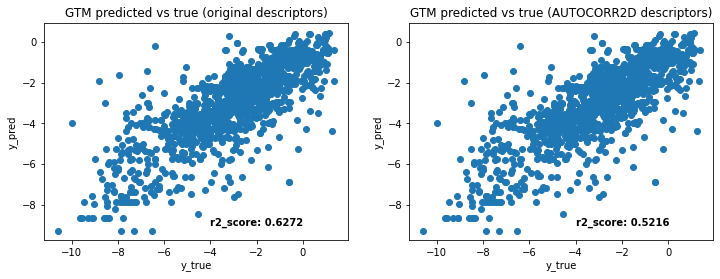

In [16]:
# Plotting the results of GTM
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title("GTM predicted vs true (original descriptors)")
ax[1].set_title("GTM predicted vs true (AUTOCORR2D descriptors)")

ax[0].set_xlabel("y_true")
ax[1].set_xlabel("y_true")
ax[0].set_ylabel("y_pred")
ax[1].set_ylabel("y_pred")

ax[0].scatter(y1_test,y1_pred)
ax[1].scatter(y1_test,y1_pred)

ax[0].text(-4,-9,"r2_score: {:.4f}".format(r2_score(y1_test,y1_pred)),fontweight="bold")
ax[1].text(-4,-9,"r2_score: {:.4f}".format(r2_score(y2_test,y2_pred)),fontweight="bold");

#### Model 2: Ridge Regression

In [122]:
# Ridge Regression model building
"""
listalpha = [0,0.001,0.01,0.1,1,10,20,50,100] # alpha constant that penalized the model parameters by l2 norm
r2_score1 = []
r2_score2 = []
predicted1 = []
predicted2 = []

step=0 # To keep track of when do we encounter the best parameters
for alpha in listalpha:
    print("Step: ",step)
    print("Current alpha: ",alpha)
    ridge1 = Ridge(alpha=alpha)
    ridge2 = Ridge(alpha=alpha)
    ridge1.fit(X1_train,y1_train.values.ravel())
    ridge2.fit(X2_train,y2_train.values.ravel())
    y1_pred = ridge1.predict(X1_test)
    y2_pred = ridge2.predict(X2_test)
    print("r2_score for model 1: ",r2_score(y1_test,y1_pred))
    print("r2_score for model 2 :",r2_score(y2_test,y2_pred))
    r2_score1.append(r2_score(y1_test,y1_pred))
    r2_score2.append(r2_score(y2_test,y2_pred))
    predicted1.append(y1_pred)
    predicted2.append(y2_pred)
    print("Finishing step: ",step)
    print("_________________")
    step+=1
""";

In [23]:
# Best Ridge regression predictors
bestr1=listalpha[np.argmax(np.array([r2_score1]))]
bestr2=listalpha[np.argmax(np.array([r2_score2]))]
print("Ridge Regression, best regularization coefficients:")
print("ridge1 (on X1): ",bestr1)
print("ridge2 (on X2): ",bestr2)

Ridge Regression, best regularization coefficients:
ridge1 (on X1):  0
ridge2 (on X2):  50


In [33]:
## Ploting the regression plots for best Ridge Regression Predictors
ridge1_pred = predicted1[listalpha.index(bestr1)]
ridge2_pred = predicted2[listalpha.index(bestr2)]

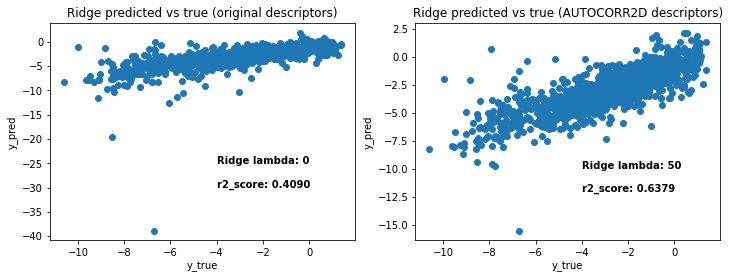

In [87]:
## Plotting the ridge regression results
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title("Ridge predicted vs true (original descriptors)")
ax[1].set_title("Ridge predicted vs true (AUTOCORR2D descriptors)")

ax[0].set_xlabel("y_true")
ax[1].set_xlabel("y_true")
ax[0].set_ylabel("y_pred")
ax[1].set_ylabel("y_pred")

ax[0].scatter(y1_test,ridge1_pred)
ax[1].scatter(y2_test,ridge2_pred)

ax[0].text(-4,-25,"Ridge lambda: 0",fontweight="bold")
ax[1].text(-4,-10,"Ridge lambda: 50",fontweight="bold")
ax[0].text(-4,-30,"r2_score: {:.4f}".format(r2_score(y1_test,ridge1_pred)),fontweight="bold")
ax[1].text(-4,-12,"r2_score: {:.4f}".format(r2_score(y2_test,ridge2_pred)),fontweight="bold");

#### Model 3: Support Vector Regression

In [40]:
# SVM Regression
from sklearn.svm import SVR

In [123]:
# SVM Regression model building
"""
listC = [0.1,1,10,100,1000] # C parameter controls the bias-variance tradeoff
svr_r2_score1 = []
svr_r2_score2 = []
svr_predicted1 = []
svr_predicted2 = []

step=0 # To keep track of when do we encounter the best parameters
for C in listC:
    print("Step: ",step)
    print("Current C: ",C)
    svr1 = SVR(kernel="rbf",C=C)
    svr2 = SVR(kernel="rbf",C=C)
    svr1.fit(X1_train,y1_train.values.ravel())
    svr2.fit(X2_train,y2_train.values.ravel())
    y1_pred = svr1.predict(X1_test)
    y2_pred = svr2.predict(X2_test)
    print("svr_r2_score for model 1: ",r2_score(y1_test,y1_pred))
    print("svr_r2_score for model 2 :",r2_score(y2_test,y2_pred))
    svr_r2_score1.append(r2_score(y1_test,y1_pred))
    svr_r2_score2.append(r2_score(y2_test,y2_pred))
    svr_predicted1.append(y1_pred)
    svr_predicted2.append(y2_pred)
    print("Finishing step: ",step)
    print("_________________")
    step+=1
""";

In [105]:
# Best svr predictors
bestsvr1=listC[np.argmax(np.array([svr_r2_score1]))]
bestsvr2=listC[np.argmax(np.array([svr_r2_score2]))]
print("Support Vector Regression, best C parameter:")
print("svr1 (on X1): ",bestsvr1)
print("svr2 (on X2): ",bestsvr2)

Support Vector Regression, best C parameter:
svr1 (on X1):  10
svr2 (on X2):  10


In [51]:
## Ploting the regression plots for best SVR Regression Predictors
svr1_pred = svr_predicted1[listC.index(bestsvr1)]
svr2_pred = svr_predicted2[listC.index(bestsvr2)]

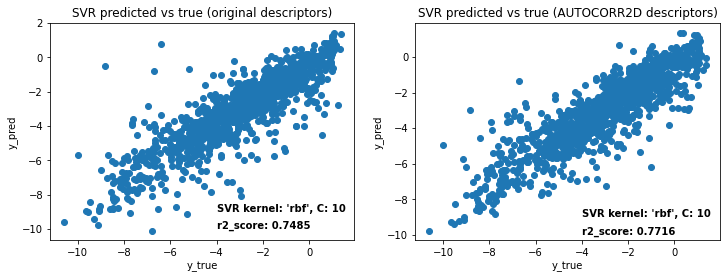

In [86]:
## Plotting the SVR regression results
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title("SVR predicted vs true (original descriptors)")
ax[1].set_title("SVR predicted vs true (AUTOCORR2D descriptors)")

ax[0].set_xlabel("y_true")
ax[1].set_xlabel("y_true")
ax[0].set_ylabel("y_pred")
ax[1].set_ylabel("y_pred")

ax[0].scatter(y1_test,svr1_pred)
ax[1].scatter(y2_test,svr2_pred)

ax[0].text(-4,-9,"SVR kernel: 'rbf', C: 10",fontweight="bold")
ax[1].text(-4,-9,"SVR kernel: 'rbf', C: 10",fontweight="bold")
ax[0].text(-4,-10,"r2_score: {:.4f}".format(r2_score(y1_test,svr1_pred)),fontweight="bold")
ax[1].text(-4,-10,"r2_score: {:.4f}".format(r2_score(y2_test,svr2_pred)),fontweight="bold");

#### Model 4: Random Forest Regression

In [61]:
# Inverting the transforms (Random forest doesn't require normalized data!)
X1_train = S1.inverse_transform(X1_train)
X1_test = S1.inverse_transform(X1_test)
X2_train = S2.inverse_transform(X2_train)
X2_test = S2.inverse_transform(X2_test)

In [68]:
# Random Forest Regression model building
# We will use the scikit learn RandomizedSearchCV module in this case
from sklearn.model_selection import RandomizedSearchCV

# List of random forest hyperparameters
max_depth = [10,20,50,None]
n_estimators = [100,200,400]
max_features = ["auto","log2"]
criterion = ["mse","mae"]

randomGrid = {
    "max_depth":max_depth,
    "n_estimators":n_estimators,
    "max_features":max_features,
    "criterion":criterion
}

rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                               param_distributions = randomGrid, 
                               n_iter = 10, 
                               cv = 3, 
                               verbose=3, 
                               random_state=42, 
                               n_jobs = -1)

In [69]:
# Now we fit the randomized search model to the first dataset
rf_random.fit(X1_train,y1_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae'],
                                        'max_depth': [10, 20, 50, None],
                                        'max_features': ['auto', 'log2'],
                                        'n_estimators': [100, 200, 400]},
                   random_state=42, verbose=3)

In [124]:
# Checking for the best parameters of the first model
rf_random.best_params_;

In [79]:
# Creating the random forest model for the second dataset, based on the
# parameters of the first dataset
rf_2 = RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=50,criterion="mae")

In [82]:
rf_2.fit(X2_train,y2_train.values.ravel())

RandomForestRegressor(criterion='mae', max_depth=50, max_features='log2',
                      n_estimators=200)

In [85]:
# Now let's predict the results
y1_pred = rf_random.predict(X1_test)
y2_pred = rf_2.predict(X2_test)

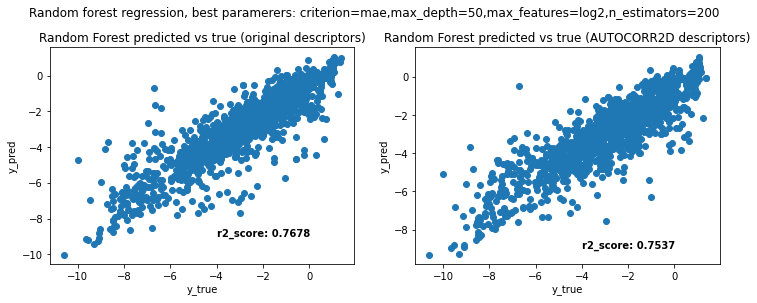

In [97]:
## Plotting the randomforest regression results
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title("Random Forest predicted vs true (original descriptors)")
ax[1].set_title("Random Forest predicted vs true (AUTOCORR2D descriptors)")

ax[0].set_xlabel("y_true")
ax[1].set_xlabel("y_true")
ax[0].set_ylabel("y_pred")
ax[1].set_ylabel("y_pred")

ax[0].scatter(y1_test,y1_pred)
ax[1].scatter(y2_test,y2_pred)

fig.suptitle("Random forest regression, best paramerers: \
criterion=mae,max_depth=50,max_features=log2,n_estimators=200",y=1.02)
ax[0].text(-4,-9,"r2_score: {:.4f}".format(r2_score(y1_test,y1_pred)),fontweight="bold")
ax[1].text(-4,-9,"r2_score: {:.4f}".format(r2_score(y2_test,y2_pred)),fontweight="bold");

#### Model 5: KNeighborsRegressor

In [126]:
# SVM Regression model building
"""
listKNN = [1,2,3,4,5,6,7,8,9,10,12,14,16,18,20,22,24,26,28,30] # List of nearest neighbors to evaluate
knn_r2_score1 = []
knn_r2_score2 = []
knn_predicted1 = []
knn_predicted2 = []

step=0 # To keep track of when do we encounter the best parameters
for NN in listKNN:
    print("Step: ",step)
    print("Current NN: ",NN)
    knn1 = KNeighborsRegressor(n_neighbors=NN,weights="distance")
    knn2 = KNeighborsRegressor(n_neighbors=NN,weights="distance")
    knn1.fit(X1_train,y1_train.values.ravel())
    knn2.fit(X2_train,y2_train.values.ravel())
    y1_pred = knn1.predict(X1_test)
    y2_pred = knn2.predict(X2_test)
    print("knn_r2_score for model 1: ",r2_score(y1_test,y1_pred))
    print("knn_r2_score for model 2 :",r2_score(y2_test,y2_pred))
    knn_r2_score1.append(r2_score(y1_test,y1_pred))
    knn_r2_score2.append(r2_score(y2_test,y2_pred))
    knn_predicted1.append(y1_pred)
    knn_predicted2.append(y2_pred)
    print("Finishing step: ",step)
    print("_________________")
    step+=1
""";

In [103]:
# Best KNN regression predictors
bestknn1=listKNN[np.argmax(np.array([knn_r2_score1]))]
bestknn2=listKNN[np.argmax(np.array([knn_r2_score2]))]
print("KNeighbors Regression, best number of neighbors parameter:")
print("knn (on X1): ",bestknn1)
print("knn (on X2): ",bestknn2)

KNeighbors Regression, best number of neighbors parameter:
knn (on X1):  10
knn (on X2):  6


In [107]:
# Plotting the regression plots for the best KNN predictors
knn1_pred = knn_predicted1[listKNN.index(bestknn1)]
knn2_pred = knn_predicted2[listKNN.index(bestknn2)]

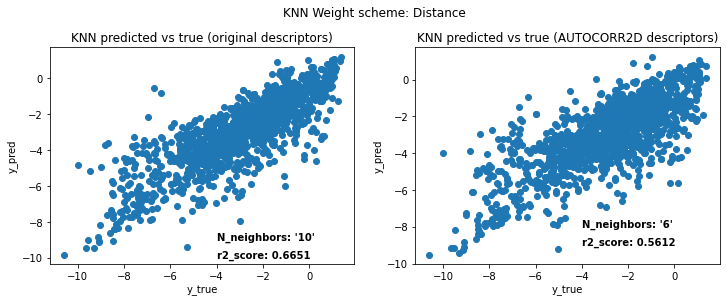

In [115]:
## Plotting the KNN regression results
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].set_title("KNN predicted vs true (original descriptors)")
ax[1].set_title("KNN predicted vs true (AUTOCORR2D descriptors)")

ax[0].set_xlabel("y_true")
ax[1].set_xlabel("y_true")
ax[0].set_ylabel("y_pred")
ax[1].set_ylabel("y_pred")

ax[0].scatter(y1_test,knn1_pred)
ax[1].scatter(y2_test,knn2_pred)

fig.suptitle("KNN Weight scheme: Distance",y=1.02)
ax[0].text(-4,-9,"N_neighbors: '10'",fontweight="bold")
ax[1].text(-4,-8,"N_neighbors: '6'",fontweight="bold")
ax[0].text(-4,-10,"r2_score: {:.4f}".format(r2_score(y1_test,knn1_pred)),fontweight="bold")
ax[1].text(-4,-9,"r2_score: {:.4f}".format(r2_score(y2_test,knn2_pred)),fontweight="bold");

## Step 3: Final report

In [148]:
# Wrapping up the report
Descriptor_sets = ["Original desciptors","AUTOCORR2D descriptors"]
ML_models = ["GTM","Ridge Regression","Support Vector Regression","Random Forest","K-Nearest Neighbors"]
r2_scores = np.array([[0.6272,0.4090,0.7485,0.7678,0.6651],[0.5216,0.6379,0.7716,0.7537,0.5612]])

Final_Data = pd.DataFrame(index=ML_models,columns=Descriptor_sets,
                         data=r2_scores.T)
Final_Data.columns.name="Descriptor Sets"
Final_Data.index.name="ML Models"

In [149]:
Final_Data

Descriptor Sets,Original desciptors,AUTOCORR2D descriptors
ML Models,,
GTM,0.6272,0.5216
Ridge Regression,0.4090,0.6379
Support Vector Regression,0.7485,0.7716
Random Forest,0.7678,0.7537
K-Nearest Neighbors,0.6651,0.5612
